<a href="https://colab.research.google.com/github/sarahajbane/notebooks/blob/main/Annotations_trial_litterrows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plastic Detection from Sentinel-2 Data – Phase 1: Annotation Evaluation

This notebook initiates the pipeline for training a plastic litter segmentation model using the **Mediterranean Sentinel-2 Litter Windrows Catalogue (2015–2021)**.

### ✅ Objectives of Phase 1:
- Load and explore the `.nc` dataset containing 14,374 plastic filament detections.
- Verify centroid and pixel-level annotations.
- Confirm suitability of annotations for generating ground truth segmentation masks.
- Visualize sample binary masks based on annotated pixels.

### ✅ Outcome:
We successfully loaded the dataset, extracted filament coordinates, and created a binary mask from the first sample, confirming that the dataset is suitable for training segmentation models.


In [ ]:
!pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 55.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from netCDF4 import Dataset

file_path = '/content/drive/MyDrive/WASP_LW_SENT2_MED_L1C_B_201506_202109_10m_6y_NRT_v1.0.nc'
#file_path = 'WASP_LW_SENT2_MED_L1C_B_201506_202109_10m_6y_NRT_v1.0.nc'
ds = Dataset(file_path, mode='r')

print("Available variables:")
print(ds.variables.keys())


Mounted at /content/drive
Available variables:
dict_keys(['s2_product', 'dec_time', 'x_centroid', 'y_centroid', 'lat_centroid', 'lon_centroid', 'n_pixels_fil', 'limits', 'pixel_x', 'pixel_y', 'pixel_spec'])


In [ ]:
# Step 1: Explore centroid information for the first 5 filaments
print("Latitude Centroids:", ds.variables['lat_centroid'][:5])
print("Longitude Centroids:", ds.variables['lon_centroid'][:5])
print("X Centroids:", ds.variables['x_centroid'][:5])
print("Y Centroids:", ds.variables['y_centroid'][:5])

# Step 2: Check number of pixels in each filament (first 5)
print("Number of pixels in filament:", ds.variables['n_pixels_fil'][:5])

# Step 3: Explore pixel locations for the first filament
pixels_x = ds.variables['pixel_x'][0]  # shape: [n_max_pixels_fil]
pixels_y = ds.variables['pixel_y'][0]

# Filter out padding values (-999)
valid_pixel_indices = pixels_x != -999
pixels_x = pixels_x[valid_pixel_indices]
pixels_y = pixels_y[valid_pixel_indices]

# Print first 10 valid pixel coordinates
print("Sample pixel (x, y) coordinates:")
for x, y in zip(pixels_x[:10], pixels_y[:10]):
    print(f"({x}, {y})")


Latitude Centroids: [36.81826531 36.46087433 36.81734118 37.00115236 36.16619288]
Longitude Centroids: [-6.48822048 -6.64526909 -6.43700488 -6.68710157 -5.99100153]
X Centroids: [2243 6103 2253  262 9275]
Y Centroids: [2468 1027 2939  644 7063]
Number of pixels in filament: [45 19 22 90 14]
Sample pixel (x, y) coordinates:
(2170, 2626)
(2171, 2623)
(2171, 2624)
(2173, 2620)
(2175, 2611)
(2175, 2613)
(2175, 2614)
(2183, 2593)
(2198, 2562)
(2199, 2560)


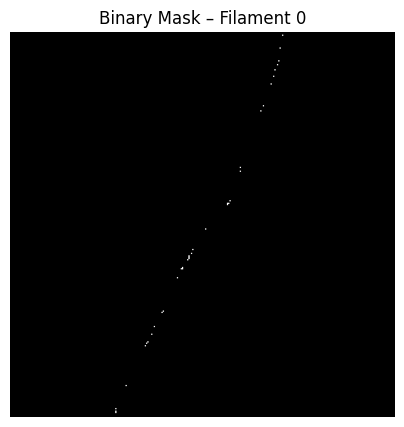

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define size of the mask canvas (adjustable – here, centered around filament)
canvas_size = 300  # pixels
center_x = ds.variables['x_centroid'][0]
center_y = ds.variables['y_centroid'][0]

# Create empty binary mask
mask = np.zeros((canvas_size, canvas_size), dtype=np.uint8)

# Get valid pixel coordinates for the first filament
pixels_x = ds.variables['pixel_x'][0]
pixels_y = ds.variables['pixel_y'][0]
valid = pixels_x != -999
pixels_x = pixels_x[valid]
pixels_y = pixels_y[valid]

# Offset coordinates to center mask on filament
for x, y in zip(pixels_x, pixels_y):
    rel_x = x - center_x + canvas_size // 2
    rel_y = y - center_y + canvas_size // 2
    if 0 <= rel_x < canvas_size and 0 <= rel_y < canvas_size:
        mask[rel_y, rel_x] = 1  # Set plastic presence = 1

# Show the binary mask
plt.figure(figsize=(5, 5))
plt.imshow(mask, cmap='gray')
plt.title("Binary Mask – Filament 0")
plt.axis('off')
plt.show()


# 📍 Phase 2: AOI Definition & Filtering

In this phase, we define and apply spatial filters to extract filament annotations within key plastic accumulation zones in the Mediterranean Sea. These Areas of Interest (AOIs) include:

- **Po River Plume** (Northern Adriatic)
- **Northern Corsica**
- **Gulf of Genova**

### ✅ Objectives:
- Define bounding boxes (~50x50 km) for each AOI.
- Visualize the AOIs on a map using Cartopy.
- Filter filament centroids to retain only those within each AOI.
- Extract pixel-level annotations and bounding boxes for selected filaments.

### ✅ Outcome:
The dataset has been filtered successfully:
- 1512 filaments in Po River Plume
- 39 in Northern Corsica
- 31 in Gulf of Genova

The pixel coordinates and bounding boxes for each AOI are now ready for mask generation or patch extraction in the next phase.


In [ ]:
# Define bounding boxes as [min_lon, min_lat, max_lon, max_lat]

AOI_BBOXES = {
    'Po_River_Plume':      [12.5, 44.8, 13.2, 45.5],   # Near the Po River delta (Northern Adriatic)
    'Northern_Corsica':    [8.5, 42.9, 9.2, 43.6],     # North of Corsica island
    'Gulf_of_Genova':      [8.5, 43.7, 9.2, 44.4],     # Ligurian Sea, near major coastal cities
}

In [ ]:
!pip install cartopy --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 107.8 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


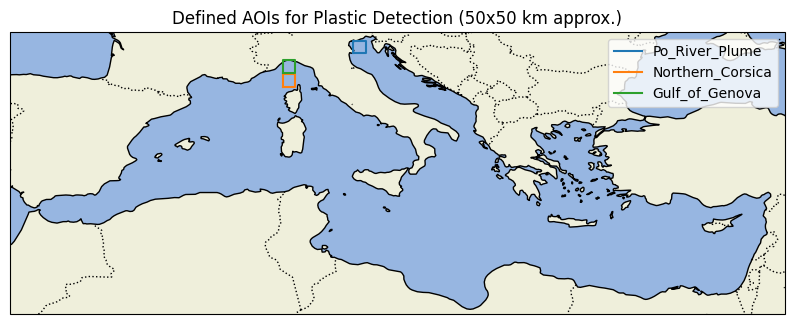

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Bounding boxes from previous step
AOI_BBOXES = {
    'Po_River_Plume':      [12.5, 44.8, 13.2, 45.5],
    'Northern_Corsica':    [8.5, 42.9, 9.2, 43.6],
    'Gulf_of_Genova':      [8.5, 43.7, 9.2, 44.4],
}

# Plot setup
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-7, 37, 30, 46], crs=ccrs.PlateCarree())  # Mediterranean bounds
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

# Plot AOIs
for name, (min_lon, min_lat, max_lon, max_lat) in AOI_BBOXES.items():
    ax.plot([min_lon, max_lon, max_lon, min_lon, min_lon],
            [min_lat, min_lat, max_lat, max_lat, min_lat],
            transform=ccrs.PlateCarree(), label=name)

# Final touches
plt.title("Defined AOIs for Plastic Detection (50x50 km approx.)")
plt.legend()
plt.show()

In [ ]:
import numpy as np

# Load all centroids
lat = ds.variables['lat_centroid'][:]
lon = ds.variables['lon_centroid'][:]

# Initialize results
filtered_filaments = {
    'Po_River_Plume': [],
    'Northern_Corsica': [],
    'Gulf_of_Genova': []
}

# Check which centroids fall in each AOI
for i in range(len(lat)):
    lat_i, lon_i = lat[i], lon[i]

    for aoi, (min_lon, min_lat, max_lon, max_lat) in AOI_BBOXES.items():
        if (min_lon <= lon_i <= max_lon) and (min_lat <= lat_i <= max_lat):
            filtered_filaments[aoi].append(i)

# Print summary
for aoi in filtered_filaments:
    print(f"{aoi}: {len(filtered_filaments[aoi])} filaments found")

Po_River_Plume: 1512 filaments found
Northern_Corsica: 39 filaments found
Gulf_of_Genova: 31 filaments found


In [ ]:
# Select AOI
aoi_name = 'Po_River_Plume'
filament_indices = filtered_filaments[aoi_name]

# Load all relevant variables
pixel_x_all = ds.variables['pixel_x']
pixel_y_all = ds.variables['pixel_y']
limits_all = ds.variables['limits']
n_pixels_all = ds.variables['n_pixels_fil']

# Store data for each filament
aoi_filaments_data = []

for idx in filament_indices:
    n_pixels = n_pixels_all[idx]

    # Get valid pixel coordinates
    px = pixel_x_all[idx][:n_pixels]
    py = pixel_y_all[idx][:n_pixels]

    # Get bounding box: [x_min, y_min, x_max, y_max]
    bbox = limits_all[idx]

    aoi_filaments_data.append({
        'index': idx,
        'n_pixels': n_pixels,
        'pixels_x': px,
        'pixels_y': py,
        'bbox': bbox
    })

# Print summary of first 3 filaments
for i, f in enumerate(aoi_filaments_data[:3]):
    print(f"\nFilament #{f['index']}")
    print(f"Number of pixels: {f['n_pixels']}")
    print(f"Bounding box: {f['bbox']}")
    print(f"First 5 pixel coords: {list(zip(f['pixels_x'][:5], f['pixels_y'][:5]))}")



Filament #3298
Number of pixels: 16
Bounding box: [8534 3246 8578 3322]
First 5 pixel coords: [(np.int16(3262), np.int16(8554)), (np.int16(3265), np.int16(8553)), (np.int16(3266), np.int16(8553)), (np.int16(3275), np.int16(8551)), (np.int16(3276), np.int16(8551))]

Filament #3299
Number of pixels: 101
Bounding box: [9050 2582 9280 2714]
First 5 pixel coords: [(np.int16(2605), np.int16(9067)), (np.int16(2605), np.int16(9069)), (np.int16(2606), np.int16(9069)), (np.int16(2606), np.int16(9070)), (np.int16(2607), np.int16(9086))]

Filament #3300
Number of pixels: 11
Bounding box: [9305 2681 9346 2710]
First 5 pixel coords: [(np.int16(2692), np.int16(9315)), (np.int16(2692), np.int16(9320)), (np.int16(2692), np.int16(9321)), (np.int16(2693), np.int16(9321)), (np.int16(2693), np.int16(9322))]


In [ ]:
len(aoi_filaments_data)

1512

# 🧪 Phase 3: Segmentation Mask Generation (Test Batch)

This phase focuses on creating binary segmentation masks from pixel-level annotations for plastic filaments.

### ✅ Objectives:
- Use pixel (x, y) coordinates and centroids from the Litter Windrows Catalog.
- Generate binary masks of size 256×256 pixels centered around each filament.
- Each mask uses:
  - `1` to represent filament/presence of plastic.
  - `0` to represent background (no plastic).
- Validate the correctness of the masks through visualization.

### 📦 Output:
- A set of sample binary masks saved as `.png` images.
- Each mask aligns with future Sentinel-2 patches for training segmentation models.

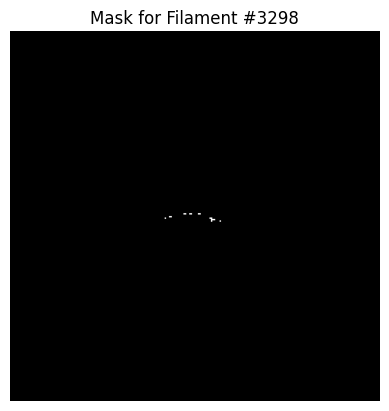

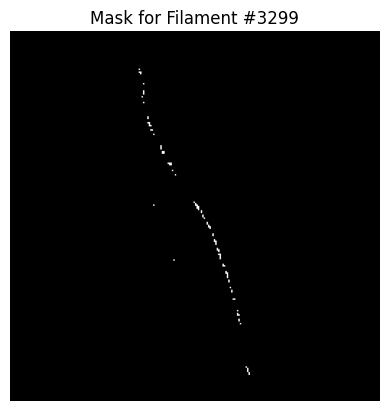

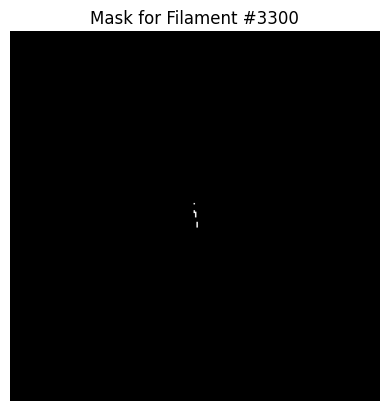

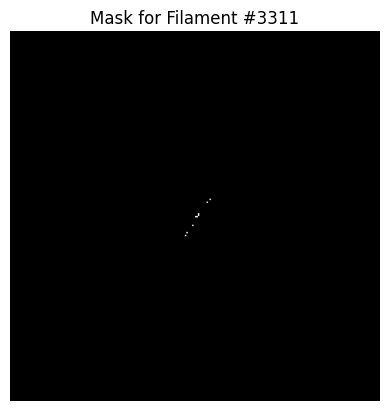

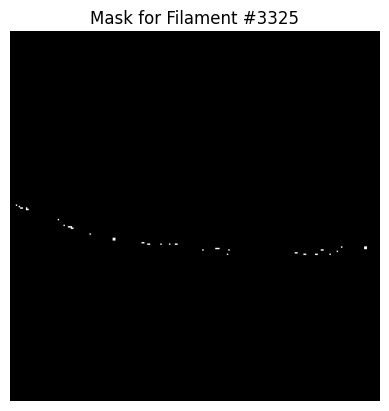

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Create output folder
output_folder = "/content/masks_test_po_river"
os.makedirs(output_folder, exist_ok=True)

# Select first 5 filaments from Po River Plume
sample_filaments = aoi_filaments_data[:5]

# Define mask size and padding
mask_size = 256  # 256x256 pixels
half_size = mask_size // 2

# Loop through each filament
for i, filament in enumerate(sample_filaments):
    # Get pixel coordinates for this filament
    px = filament['pixels_x']
    py = filament['pixels_y']

    # Get centroid to center the patch
    cx = ds.variables['x_centroid'][filament['index']]
    cy = ds.variables['y_centroid'][filament['index']]

    # Create an empty binary mask
    mask = np.zeros((mask_size, mask_size), dtype=np.uint8)

    # Map each filament pixel to the mask relative to centroid
    for x, y in zip(px, py):
        rel_x = x - cx + half_size
        rel_y = y - cy + half_size

        # Ensure coordinates are inside the mask
        if 0 <= rel_x < mask_size and 0 <= rel_y < mask_size:
            mask[rel_y, rel_x] = 1  # 1 = plastic pixel

    # Save the binary mask as a PNG file
    filename = f"{output_folder}/mask_{filament['index']}.png"
    Image.fromarray(mask * 255).save(filename)

    # Optional: Show the mask
    plt.imshow(mask, cmap='gray')
    plt.title(f"Mask for Filament #{filament['index']}")
    plt.axis('off')
    plt.show()


# 🌍 Phase 4: RGB Patch Retrieval via Google Earth Engine (GEE)

This phase integrates Earth Engine into the pipeline to retrieve Sentinel-2 image patches aligned with plastic filament annotations.

### ✅ Objectives:
- Use centroid latitude, longitude, and acquisition date to locate the matching satellite imagery.
- Query Sentinel-2 Surface Reflectance (`S2_SR`) as the primary source.
- Automatically fall back to TOA (`S2`) when SR imagery is unavailable.
- Clip 256×256 pixel RGB patches (B4, B3, B2) centered on each filament.

### ✅ Tools:
- Earth Engine Python API via `ee` and `geemap`
- Sentinel-2 collections: `COPERNICUS/S2_SR` and `COPERNICUS/S2`

### ✅ Outcome:
An RGB image patch is now correctly retrieved and visualized for each filament.
This confirms readiness for batch patch extraction.


In [ ]:
import pandas as pd
from datetime import datetime
import os

os.makedirs("patch_metadata", exist_ok=True)

lat_all = ds.variables['lat_centroid']
lon_all = ds.variables['lon_centroid']
time_all = ds.variables['dec_time']
s2_product_all = ds.variables['s2_product']

rows = []
for filament in sample_filaments:
    idx = filament['index']

    lat = float(lat_all[idx])
    lon = float(lon_all[idx])
    dec_year = float(time_all[idx])

    year = int(dec_year)
    remainder = dec_year - year
    days = int(remainder * 365.25)
    date_str = datetime(year, 1, 1) + pd.Timedelta(days=days)
    date = date_str.strftime('%Y-%m-%d')

    # ✅ FIXED: Decode the product name correctly
    s2_product = s2_product_all[idx].tobytes().decode('utf-8').strip()

    rows.append({
        'filament_id': idx,
        'aoi': 'Po_River_Plume',
        'latitude': lat,
        'longitude': lon,
        'acquisition_date': date,
        's2_product': s2_product
    })

# Create DataFrame and save
df = pd.DataFrame(rows)
df.to_csv("patch_metadata/po_river_test_patches.csv", index=False)

df.head()

,filament_id,aoi,latitude,longitude,acquisition_date,s2_product
0,3298,Po_River_Plume,44.820392,12.568881,2016-04-29,S2A_MSIL1C_20160429T101032_N0201_R022_T32TQQ_2...
1,3299,Po_River_Plume,44.879898,12.642329,2016-06-18,S2A_MSIL1C_20160618T101032_N0204_R022_T32TQQ_2...
2,3300,Po_River_Plume,44.875337,12.660788,2016-06-18,S2A_MSIL1C_20160618T101032_N0204_R022_T32TQQ_2...
3,3311,Po_River_Plume,44.868262,12.685901,2016-08-26,S2A_MSIL1C_20160827T101022_N0204_R022_T32TQQ_2...
4,3325,Po_River_Plume,44.997646,12.539868,2016-09-25,S2A_MSIL1C_20160926T101022_N0204_R022_T32TQQ_2...


In [ ]:
!pip install earthengine-api geemap --quiet

import ee
import geemap

# Authenticate once (opens Google login)
ee.Authenticate()

# Initialize the Earth Engine session
ee.Initialize(project='ee-mujtabanaqvi29')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.1 MB/s eta 0:00:00


In [ ]:
row = df.iloc[0]

# Geometry setup
point = ee.Geometry.Point([row['longitude'], row['latitude']])
patch_size = 1280  # 1280 meters = 128 pixels on either side (256x256 patch)
region = point.buffer(patch_size).bounds()

# Date setup
date_start = row['acquisition_date']
date_end = pd.to_datetime(date_start) + pd.Timedelta(days=10)
date_end_str = date_end.strftime('%Y-%m-%d')

# Try S2_SR first
print("Trying S2_SR...")
image_sr = (ee.ImageCollection('COPERNICUS/S2_SR')
            .filterBounds(point)
            .filterDate(date_start, date_end_str)
            .sort('CLOUDY_PIXEL_PERCENTAGE')
            .first())

if image_sr and image_sr.getInfo():  # Check if image_sr is not null
    print("✅ Using Surface Reflectance image.")
    image = image_sr.select(['B4', 'B3', 'B2'])

else:
    print("⚠️ No S2_SR image found. Trying S2 TOA...")
    image_toa = (ee.ImageCollection('COPERNICUS/S2')
                 .filterBounds(point)
                 .filterDate(date_start, date_end_str)
                 .sort('CLOUDY_PIXEL_PERCENTAGE')
                 .first())

    if image_toa and image_toa.getInfo():
        print("✅ Using TOA image.")
        image = image_toa.select(['B4', 'B3', 'B2'])
    else:
        raise ValueError("❌ No suitable image found in either S2_SR or S2 TOA collections.")

# Clip to patch area
rgb_patch = image.clip(region)

# Display in Colab
Map = geemap.Map()
Map.centerObject(region, 12)
Map.addLayer(rgb_patch, {'min': 0, 'max': 3000}, 'RGB Patch')
Map

Trying S2_SR...
⚠️ No S2_SR image found. Trying S2 TOA...
✅ Using TOA image.


Map(center=[44.820393562917126, 12.568906795885402], controls=(WidgetControl(options=['position', 'transparent…

# 📦 Phase 5: Batch Export of Image Patches to Google Drive

This phase involves exporting Sentinel-2 image patches from Earth Engine for each plastic filament detected in the Litter Windrows Catalog.

### ✅ Objectives:
- Export 256×256 pixel RGB patches centered on filament centroids.
- Use GEE's batch export capabilities to send patches to Google Drive.
- Start with a small batch (e.g., 5 test patches) to validate the workflow.
- Prepare for scaling to all 1582 filtered filaments across the 3 AOIs.

### ✅ Export Settings:
- **Resolution**: 10 meters per pixel
- **Size**: 2.56×2.56 km (256×256 pixels)
- **Bands**: B4 (Red), B3 (Green), B2 (Blue)
- **Format**: `.tif` files (GeoTIFF)
- **Output**: Saved in a folder on Google Drive for later download

➡️ Once verified, this batch export will be scaled to all AOIs and used alongside binary masks for segmentation model training.


In [ ]:
# Export folder name in Google Drive
drive_folder = 'plastic_patches_test'

# Patch size
patch_size_m = 1280  # 1280 meters = 256×256 at 10m resolution

# Loop through first 5 rows
for i in range(5):
    row = df.iloc[i]
    lat, lon = row['latitude'], row['longitude']
    date_start = row['acquisition_date']
    date_end = pd.to_datetime(date_start) + pd.Timedelta(days=10)

    point = ee.Geometry.Point([lon, lat])
    region = point.buffer(patch_size_m).bounds()
    image = None

    # Try Surface Reflectance
    s2_sr = (ee.ImageCollection('COPERNICUS/S2_SR')
             .filterBounds(point)
             .filterDate(date_start, date_end.strftime('%Y-%m-%d'))
             .sort('CLOUDY_PIXEL_PERCENTAGE')
             .first())

    if s2_sr and s2_sr.getInfo():
        image = s2_sr.select(['B4', 'B3', 'B2'])
        print(f"✅ Using S2_SR for filament {row['filament_id']}")
    else:
        # Fallback to TOA
        s2_toa = (ee.ImageCollection('COPERNICUS/S2')
                  .filterBounds(point)
                  .filterDate(date_start, date_end.strftime('%Y-%m-%d'))
                  .sort('CLOUDY_PIXEL_PERCENTAGE')
                  .first())
        if s2_toa and s2_toa.getInfo():
            image = s2_toa.select(['B4', 'B3', 'B2'])
            print(f"⚠️ Fallback to S2 TOA for filament {row['filament_id']}")
        else:
            print(f"❌ No image found for filament {row['filament_id']}")
            continue  # skip if no image found

    # Set export task
    task = ee.batch.Export.image.toDrive(
        image=image.clip(region),
        description=f'filament_patch_{int(row["filament_id"])}',
        folder=drive_folder,
        fileNamePrefix=f'filament_patch_{int(row["filament_id"])}',
        region=region.getInfo()['coordinates'],
        scale=10,
        maxPixels=1e9,
        fileFormat='GeoTIFF'
    )

    task.start()
    print(f"🚀 Export task started for filament {row['filament_id']}")


⚠️ Fallback to S2 TOA for filament 3298
🚀 Export task started for filament 3298
⚠️ Fallback to S2 TOA for filament 3299
🚀 Export task started for filament 3299
⚠️ Fallback to S2 TOA for filament 3300
🚀 Export task started for filament 3300
⚠️ Fallback to S2 TOA for filament 3311
🚀 Export task started for filament 3311
⚠️ Fallback to S2 TOA for filament 3325
🚀 Export task started for filament 3325


# 🧪 Phase 6: Dataset Preparation for Model Training

This phase focuses on preparing the image–mask pairs for training a segmentation model (e.g., UNet with fast.ai or PyTorch).

### ✅ Objectives:
- Download `.tif` image patches from Google Drive into Colab.
- Match them with corresponding `.png` binary masks.
- Organize everything into:
  - `dataset/images/` – Input satellite image patches
  - `dataset/masks/` – Ground truth segmentation masks
- Visualize image–mask pairs to ensure alignment.
- Prepare data for direct use in model training (next phase).


In [ ]:
import os
import shutil

# Define destination folders
local_image_dir = 'dataset/images'
local_mask_dir = 'dataset/masks'

# Ensure directories exist
os.makedirs(local_image_dir, exist_ok=True)
os.makedirs(local_mask_dir, exist_ok=True)

# Copy image patches (.tif) from Drive folder
patch_source = '/content/drive/MyDrive/plastic_patches_test'
for file in os.listdir(patch_source):
    if file.endswith('.tif'):
        shutil.copyfile(f"{patch_source}/{file}", f"{local_image_dir}/{file}")

# Copy corresponding masks (.png)
mask_source = '/content/masks_test_po_river'
for file in os.listdir(mask_source):
    if file.endswith('.png'):
        shutil.copyfile(f"{mask_source}/{file}", f"{local_mask_dir}/{file}")

print("✅ Image patches and masks organized in 'dataset/images' and 'dataset/masks'")

✅ Image patches and masks organized in 'dataset/images' and 'dataset/masks'


In [ ]:
!pip install rasterio --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 86.0 MB/s eta 0:00:00


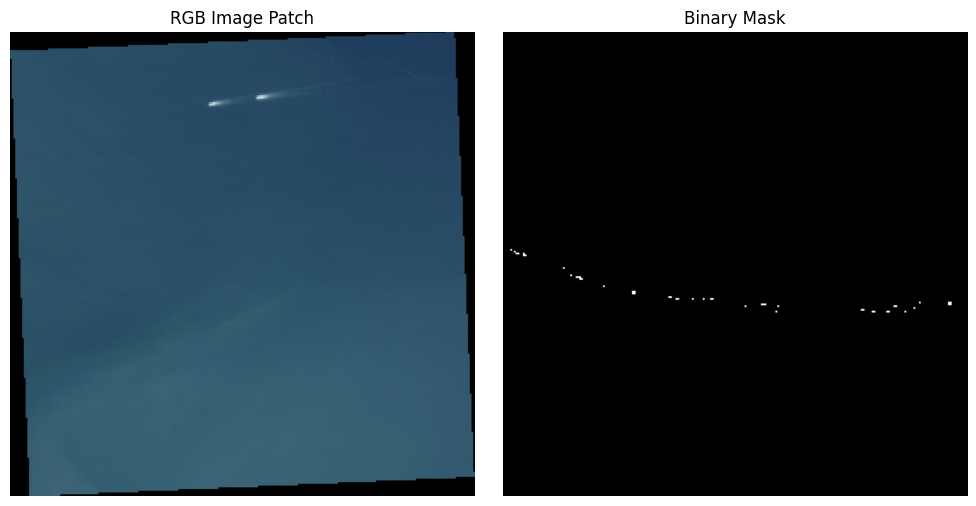

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import rasterio
import glob
import numpy as np

# Load one image–mask pair by filament ID
filament_id = 3325  # Change to test others , other filament_ids = [3298, 3299, 3300, 3311, 3325]

# File paths
img_path = f"dataset/images/filament_patch_{filament_id}.tif"
mask_path = f"dataset/masks/mask_{filament_id}.png"

# Load image (rasterio handles GeoTIFF)
with rasterio.open(img_path) as src:
    rgb = src.read([1, 2, 3])  # B4, B3, B2
    rgb = np.transpose(rgb, (1, 2, 0))  # Convert to HWC for display

# Normalize for visualization
rgb_vis = (rgb / np.max(rgb)) if np.max(rgb) > 1 else rgb

# Load mask
mask = Image.open(mask_path)

# Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rgb_vis)
plt.title("RGB Image Patch")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Binary Mask")
plt.axis('off')

plt.tight_layout()
plt.show()

# ☁️ Phase 7: Cloud Filtering Strategy & Export Planning

This section outlines the strategy for filtering and exporting high-quality Sentinel-2 image patches for plastic detection model training.

### ✅ Strategy Overview:
1. **Cloud Filtering Assessment**
   - Check how many of the filtered filaments are usable after applying:
     - `< 20%` cloud threshold
     - `< 10%` cloud threshold
   - Use Sentinel-2 Surface Reflectance (`S2_SR`) collection for accurate metadata.

2. **Visual Inspection**
   - Manually check more sample image–mask pairs after filtering.
   - Assess quality: glint, haze, clipping, or heavy cloud coverage.

3. **Download Plan**
   - Export image patches in two formats for all accepted samples:
     - **RGB only** (B4, B3, B2) – for lightweight models
     - **All bands** (13 bands) – for advanced spectral training
   - Use Earth Engine export functionality and organize output into appropriate training folders.

### 📁 Output:
- Number of usable filaments per threshold
- Visual confirmation of patch quality
- Export scripts ready for full dataset extraction

In [ ]:
from datetime import datetime

rows = []

for aoi, indices in filtered_filaments.items():
    for idx in indices:
        lat = float(ds.variables['lat_centroid'][idx])
        lon = float(ds.variables['lon_centroid'][idx])
        dec_year = float(ds.variables['dec_time'][idx])

        year = int(dec_year)
        remainder = dec_year - year
        days = int(remainder * 365.25)
        date_str = datetime(year, 1, 1) + pd.Timedelta(days=days)
        date = date_str.strftime('%Y-%m-%d')

        s2_product = ds.variables['s2_product'][idx].tobytes().decode('utf-8').strip()

        rows.append({
            'filament_id': idx,
            'aoi': aoi,
            'latitude': lat,
            'longitude': lon,
            'acquisition_date': date,
            's2_product': s2_product
        })

# Save as CSV
df = pd.DataFrame(rows)
df.to_csv("all_filtered_filaments.csv", index=False)

print(f"✅ Saved metadata for {len(df)} filaments to all_filtered_filaments.csv")

✅ Saved metadata for 1582 filaments to all_filtered_filaments.csv


In [ ]:
df = pd.read_csv("all_filtered_filaments.csv")

In [ ]:
""" Dont run this cell, the next code cell accomodate this
# Set thresholds to test
thresholds = [20, 10]
results = {thresh: {"accepted": 0, "rejected": 0} for thresh in thresholds}

for i in range(len(df)):
    row = df.iloc[i]
    lat, lon = row['latitude'], row['longitude']
    date_start = row['acquisition_date']
    date_end = pd.to_datetime(date_start) + pd.Timedelta(days=10)

    point = ee.Geometry.Point([lon, lat])

    try:
        image = (ee.ImageCollection('COPERNICUS/S2_SR')
                 .filterBounds(point)
                 .filterDate(date_start, date_end.strftime('%Y-%m-%d'))
                 .sort('CLOUDY_PIXEL_PERCENTAGE')
                 .first())

        cloud_pct = image.get('CLOUDY_PIXEL_PERCENTAGE').getInfo()

        for thresh in thresholds:
            if cloud_pct < thresh:
                results[thresh]['accepted'] += 1
            else:
                results[thresh]['rejected'] += 1

    except:
        for thresh in thresholds:
            results[thresh]['rejected'] += 1

# Print results
for thresh in thresholds:
    total = results[thresh]['accepted'] + results[thresh]['rejected']
    print(f"☁️ Threshold < {thresh}%")
    print(f"   ✅ Accepted: {results[thresh]['accepted']}")
    print(f"   ❌ Rejected: {results[thresh]['rejected']}")
    print(f"   📊 Total Checked: {total}\n")
    """"

☁️ Threshold < 20%
   ✅ Accepted: 1298
   ❌ Rejected: 284
   📊 Total Checked: 1582

☁️ Threshold < 10%
   ✅ Accepted: 1234
   ❌ Rejected: 348
   📊 Total Checked: 1582



# ☁️ Phase 8: Cloud-Filtered Export of Image Patches (10% Threshold)

This section initiates the full export of Sentinel-2 image patches, using only high-quality samples where the total scene cloud coverage is less than 10%. This improves the reliability and visibility of plastic litter filaments in the dataset.

### ✅ Objectives:
- Filter out scenes with >10% cloud coverage using `CLOUDY_PIXEL_PERCENTAGE`
- Limit training and testing images to only the 1234 cleanest filament detections
- Export two types of image patches for each filament:
  - **RGB only** (B4, B3, B2)
  - **Multispectral MARIDA-style (11 bands)** for full spectral model training
- All patches are 256×256 pixels (2.56×2.56 km at 10m resolution), centered on each filament
- Binary masks generated earlier will be reused to train segmentation models

### 📁 Output Folder Structure:
- `plastic_patches_rgb/` – 1234 RGB `.tif` patches (B4, B3, B2)
- `plastic_patches_allbands/` – 1234 11-band `.tif` patches (MARIDA-style)
- `dataset/masks/` – Binary `.png` masks (already generated)


The next snippet takes around 30-45 minutes.

In [ ]:
# Load full metadata again
df = pd.read_csv("all_filtered_filaments.csv")

accepted_10pct_ids = []

for i in range(len(df)):
    row = df.iloc[i]
    lat, lon = row['latitude'], row['longitude']
    date_start = row['acquisition_date']
    date_end = pd.to_datetime(date_start) + pd.Timedelta(days=10)

    point = ee.Geometry.Point([lon, lat])

    try:
        image = (ee.ImageCollection('COPERNICUS/S2_SR')
                 .filterBounds(point)
                 .filterDate(date_start, date_end.strftime('%Y-%m-%d'))
                 .sort('CLOUDY_PIXEL_PERCENTAGE')
                 .first())

        cloud_pct = image.get('CLOUDY_PIXEL_PERCENTAGE').getInfo()

        if cloud_pct < 10:
            accepted_10pct_ids.append(row['filament_id'])

    except:
        continue

# Filter the original DataFrame and save
df_filtered = df[df['filament_id'].isin(accepted_10pct_ids)].reset_index(drop=True)
df_filtered.to_csv("filtered_cloud10_filaments.csv", index=False)

print(f"✅ Saved {len(df_filtered)} filaments with <10% cloud to 'filtered_cloud10_filaments.csv'")

✅ Saved 1234 filaments with <10% cloud to 'filtered_cloud10_filaments.csv'


The Following snippet donwloads the first 300 images only. (not checked so far), will take alot of time.

In [ ]:
# Load only first 300 rows
df = pd.read_csv("filtered_cloud10_filaments.csv").head(300)

patch_size_m = 1280
rgb_bands = ['B4', 'B3', 'B2']
marida_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']

for i, row in df.iterrows():
    lat, lon = row['latitude'], row['longitude']
    date_start = row['acquisition_date']
    date_end = pd.to_datetime(date_start) + pd.Timedelta(days=10)
    point = ee.Geometry.Point([lon, lat])
    region = point.buffer(patch_size_m).bounds()
    fid = int(row['filament_id'])

    image = (ee.ImageCollection('COPERNICUS/S2_SR')
             .filterBounds(point)
             .filterDate(date_start, date_end.strftime('%Y-%m-%d'))
             .sort('CLOUDY_PIXEL_PERCENTAGE')
             .first())

    try:
        image.getInfo()
    except:
        print(f"❌ Skipping {fid}, no image found")
        continue

    # Export RGB
    ee.batch.Export.image.toDrive(
        image=image.select(rgb_bands).clip(region),
        description=f'RGB_patch_{fid}',
        folder='plastic_patches_rgb',
        fileNamePrefix=f'patch_rgb_{fid}',
        region=region.getInfo()['coordinates'],
        scale=10,
        maxPixels=1e9
    ).start()

    # Export MARIDA bands (optional, disable if not needed)
    ee.batch.Export.image.toDrive(
        image=image.select(marida_bands).clip(region),
        description=f'AllBands_patch_{fid}',
        folder='plastic_patches_allbands',
        fileNamePrefix=f'patch_allbands_{fid}',
        region=region.getInfo()['coordinates'],
        scale=10,
        maxPixels=1e9
    ).start()

    print(f"🚀 Export task started for filament {fid} [{i+1}/300]")
